In [2]:
import os
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:1


In [4]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

vocab_size = 64
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

p_ref = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
p_ref.load_state_dict(torch.load('../model_weights/mdm_gmm_type2_64_copy.pth'))
p_ref.eval()

MaskedDiffusion(
  (denoising_model): MLP(
    (embedding): Embedding(65, 64)
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=64, out_features=130, bias=True)
    )
  )
)

In [9]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - ((x0 - 0.5) * 12) ** 2
    reward_x1 = - ((x1 - 0.5) * 12 - 1) ** 2 / 10 
    
    reward = (x[:, 0, :-1] * reward_x0 + x[:, 1, :-1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.

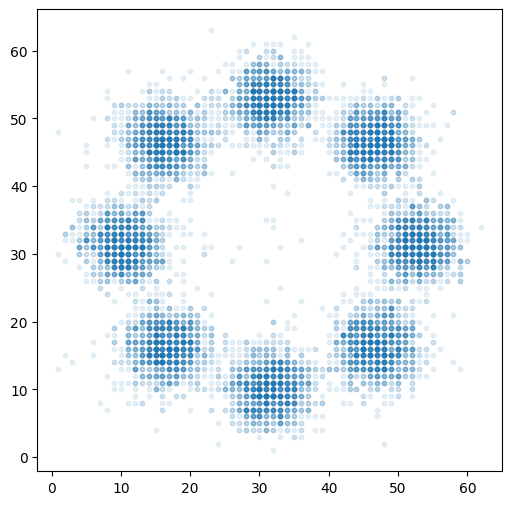

Pre-trained distribution Reward: -8.770183563232422


In [6]:
# Visualize pre-trained model samples
with torch.no_grad():
    pretrained_model_samples = p_ref.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(pretrained_model_samples[:, 0], pretrained_model_samples[:, 1], s=10, alpha=0.1)
plt.show()

rewards = compute_rewards(F.one_hot(torch.from_numpy(pretrained_model_samples), num_classes=num_categories).float())
pretrained_samples_reward = rewards.mean().item()
print(f"Pre-trained distribution Reward: {pretrained_samples_reward}")

Visualize target distribution

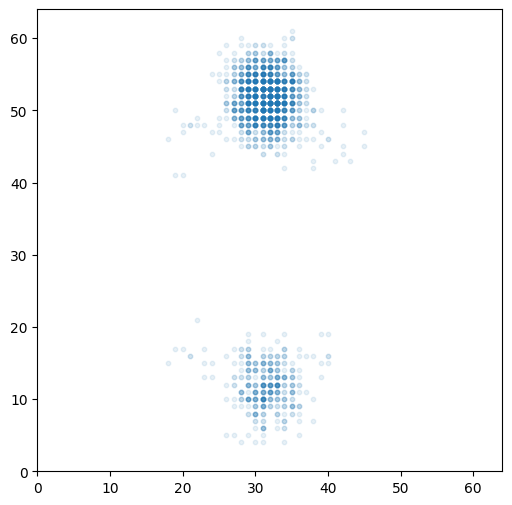

Target Reward: -1.3922785520553589
Diversity: 338


In [10]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = gaussian_mixture.generate_samples(type="2", n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.1)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
target_samples_reward = target_rewards.mean().item()
print(f"Target Reward: {target_samples_reward}")
target_samples_diversity = np.unique(target_samples, axis=0).shape[0]
print(f"Diversity: {target_samples_diversity}")

In [11]:
@torch.no_grad()
def estimate_reward(probs, num_samples, method='mean'):
    B = probs.shape[0]
    dist = torch.distributions.Categorical(probs=probs)
    samples = dist.sample((num_samples,)).reshape(num_samples * B, *input_shape)
    rewards = compute_rewards(F.one_hot(samples, num_classes=num_categories).float()).reshape(num_samples, B)
    if method == 'mean':
        return rewards.mean(dim=0) # E[r(x)]
    elif method == 'logmeanexp':
        return rewards.logsumexp(dim=0) - math.log(num_samples) # log E[exp(r(x))]
    else:
        raise ValueError(f"Unknown method: {method}")

Load model to optimize

In [13]:
q_phi = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
q_phi.load_state_dict(torch.load('../model_weights/mdm_gmm_type2_64_copy.pth'))
q_phi.eval()

f_psi = torch.nn.Parameter(torch.zeros(q_phi.num_timesteps, device=device))

In [14]:
batch_size = 128
lr = 0.001
optimizer = torch.optim.Adam(list(q_phi.parameters()) + [f_psi], lr=lr)
num_epochs = 100
batches_per_epoch = 20
patience = 5
sample_onpolicy = True
num_samples_for_reward_estimate = 10
reward_estimate_method = 'logmeanexp'

model_save_dir = '../model_weights/log_variance_loss'
os.makedirs(model_save_dir, exist_ok=True)
ckpt_path = f'{model_save_dir}/mdm_gmm1.pth'

In [15]:
loss_trace = []
reward_trace = []

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 1/100,  Loss: 253.62958221435548


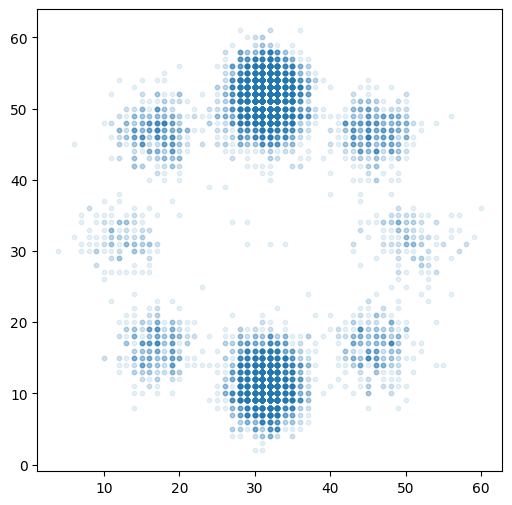

Reward: -3.048546314239502
Saved model weights.


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 2/100,  Loss: 170.75670928955077


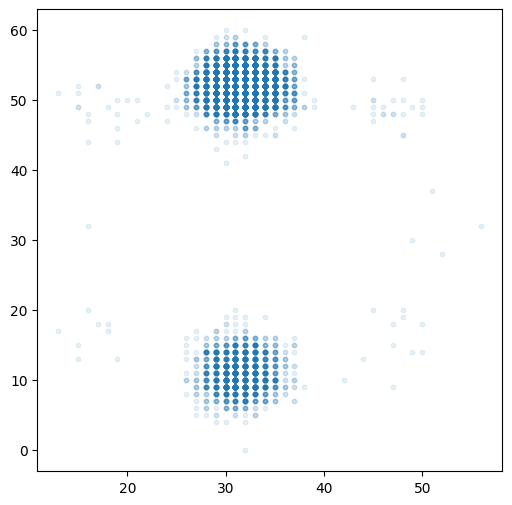

Reward: -1.3785253763198853
Saved model weights.


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 3/100,  Loss: 154.26885147094725


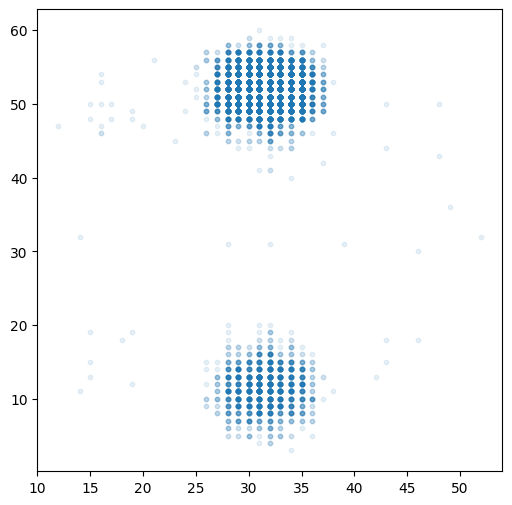

Reward: -1.3387092351913452
Saved model weights.


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch 4/100,  Loss: 162.80503692626954


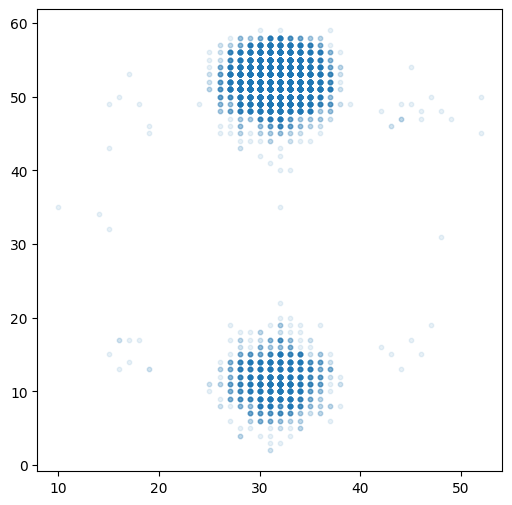

Reward: -1.384708285331726


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Epoch 5/100,  Loss: 154.1978271484375


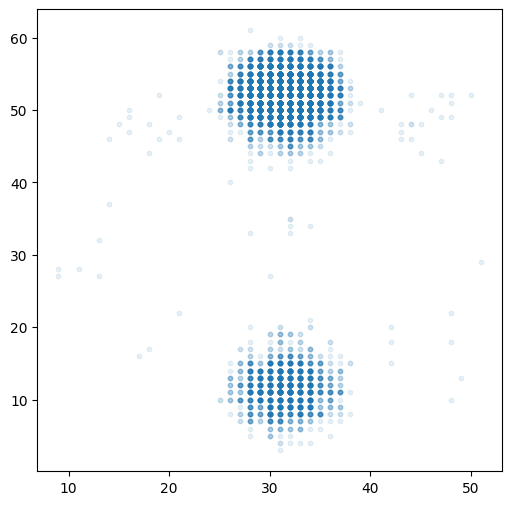

Reward: -1.3931963443756104
Saved model weights.


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch 6/100,  Loss: 155.50789794921874


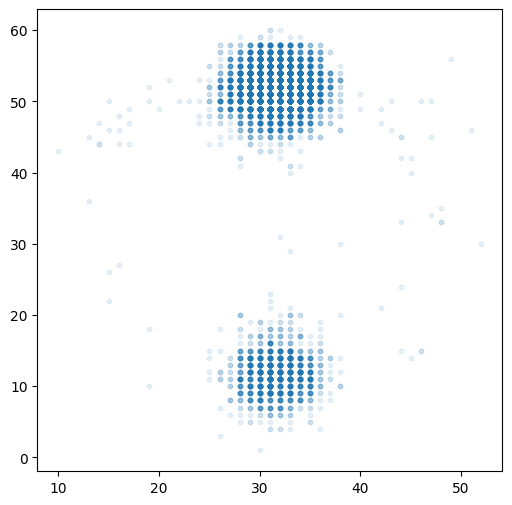

Reward: -1.3209154605865479


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 7/100,  Loss: 156.4833526611328


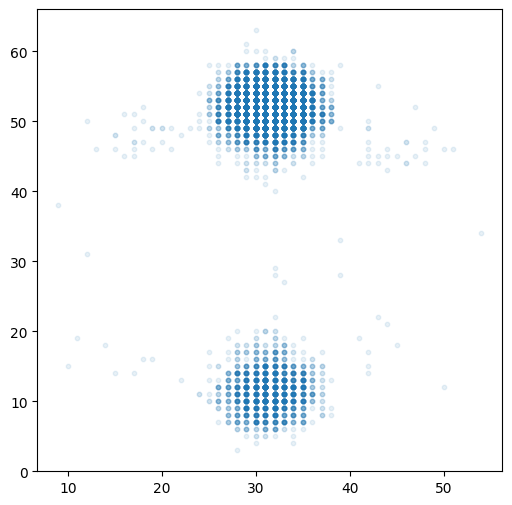

Reward: -1.4032491445541382


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch 8/100,  Loss: 162.32163772583007


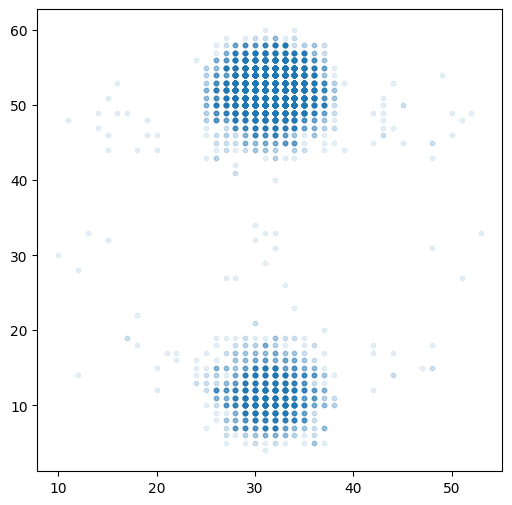

Reward: -1.4237329959869385


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch 9/100,  Loss: 154.90034408569335


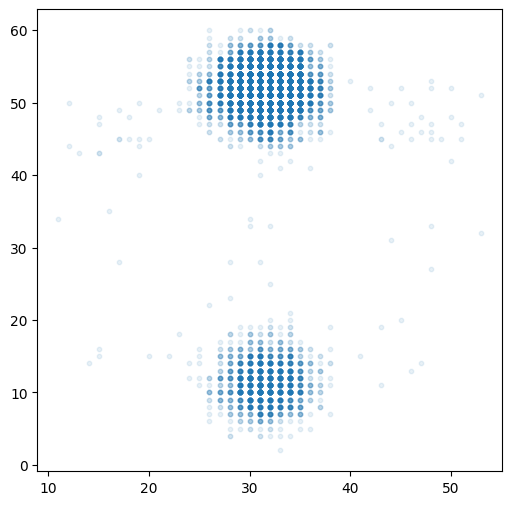

Reward: -1.3842995166778564


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 10/100,  Loss: 158.60956344604492


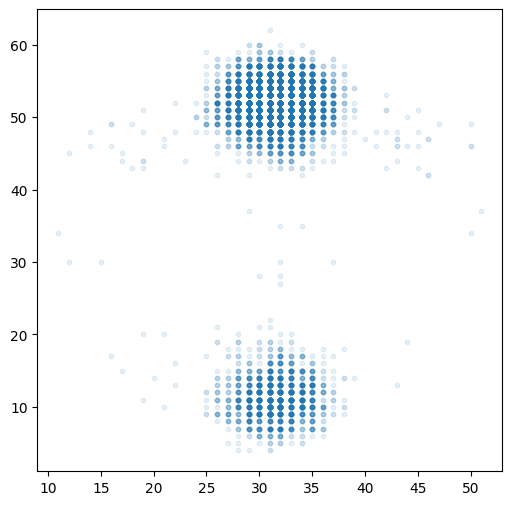

Reward: -1.3795660734176636


In [16]:
L = math.prod(q_phi.input_shape)

# Training loop
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    for batch_idx in tqdm(range(batches_per_epoch)):
        q_phi.train()
        
        rewards_prev = None
        log_prob_p_ref = None
        log_prob_q_phi = None
        loss = 0
        
        # Generate batch_size samples from q_phi
        z_t = torch.full((batch_size, L), q_phi.mask_index, device=device) # Intialize with all masks
        for i in range(q_phi.num_timesteps, 0, -1):
            # Invoke pretrained and finetune models
            q_phi_zs_given_zt, q_phi_z0_given_zt = q_phi.sample_step(
                F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
            )
            with torch.no_grad():
                p_ref_zs_given_zt, p_ref_z0_given_zt = p_ref.sample_step(
                    F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
                )
            # Estimate rewards
            rewards = estimate_reward(p_ref_z0_given_zt, num_samples_for_reward_estimate, method=reward_estimate_method)
            
            if rewards_prev is not None:
                assert log_prob_p_ref is not None and log_prob_q_phi is not None
                
                log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
                log_variance = (log_w - f_psi[i]) ** 2
                loss += log_variance.mean(dim=0) # take mean across batch dimension
            
            q_phi_dist = torch.distributions.Categorical(probs=q_phi_zs_given_zt)
            p_ref_dist = torch.distributions.Categorical(probs=p_ref_zs_given_zt)
            
            if sample_onpolicy:
                z_s = q_phi_dist.sample()
            else:
                z_s = p_ref_dist.sample()
                
            log_prob_q_phi = q_phi_dist.log_prob(z_s).sum(dim=1)
            log_prob_p_ref = p_ref_dist.log_prob(z_s).sum(dim=1)
            
            # Update for next step
            z_t = z_s
            rewards_prev = rewards
            
        z_0 = z_t.reshape(batch_size, *input_shape)
        # Compute rewards
        rewards = compute_rewards(F.one_hot(z_0, num_classes=num_categories).float())
        
        assert rewards_prev is not None and log_prob_p_ref is not None and log_prob_q_phi is not None
        log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
        log_variance = (log_w - f_psi[0]) ** 2
        loss += log_variance.mean(dim=0) # take mean across batch dimension
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        # print(f"Batch #{batch_idx}, Loss: {loss.item()}")
    
    q_phi.eval()
    avg_loss = total_epoch_loss / batches_per_epoch
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)
    
    with torch.no_grad():
        model_samples = q_phi.sample(num_samples=10000, device=device).cpu()     
    plt.figure(figsize=(6, 6))
    plt.scatter(model_samples[:, 0], model_samples[:, 1], s=10, alpha=0.1)
    plt.show()

    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}")
    reward_trace.append(rewards.mean().item())
    
    if loss_trace[-1] == min(loss_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path)
        print("Saved model weights.")
        
    if min(loss_trace) < min(loss_trace[-patience:]):
        break
    

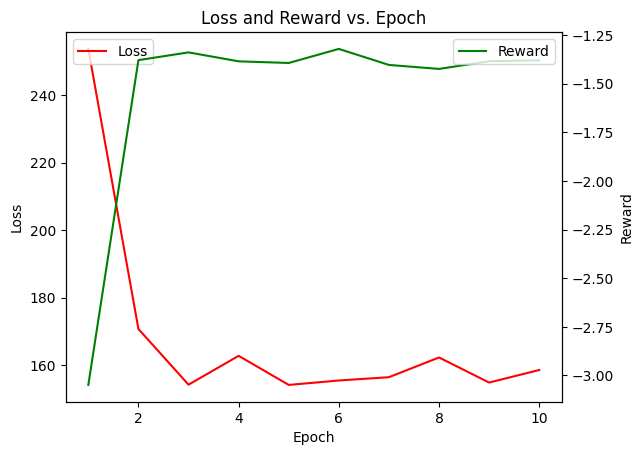

In [17]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()